In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mediapipe as mp
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# constants
ASL_CLASSES = [chr(ord("a") + i) for i in range(26)]
SPLITS = ["train", "val", "test"]

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True, max_num_hands=1, min_detection_confidence=0.7
)

I0000 00:00:1742900852.475987 3802480 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
def maintain_aspect_ratio_resize(image, target_size):
    h, w = image.shape[:2]
    target_h, target_w = target_size
    scale = min(target_h / h, target_w / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (new_w, new_h))
    square = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    square[y_offset : y_offset + new_h, x_offset : x_offset + new_w] = resized
    return square


def process_image_with_mediapipe(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    if results.multi_hand_landmarks:
        h, w = image.shape[:2]
        landmarks = results.multi_hand_landmarks[0]
        x_coords = [int(landmark.x * w) for landmark in landmarks.landmark]
        y_coords = [int(landmark.y * h) for landmark in landmarks.landmark]
        x1, y1 = max(0, min(x_coords) - 20), max(0, min(y_coords) - 20)
        x2, y2 = min(w, max(x_coords) + 20), min(h, max(y_coords) + 20)
        hand_roi = image[y1:y2, x1:x2]
        if hand_roi.size > 0:
            return maintain_aspect_ratio_resize(hand_roi, (224, 224))
    return None


def prepare_dataset(source_dir, output_dir, split_ratio=0.25):
    os.makedirs(output_dir, exist_ok=True)
    splits = SPLITS
    class_names = [
        d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))
    ]
    for split in splits:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for class_name in class_names:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

    for class_name in tqdm(class_names, desc="Processing classes"):
        class_dir = os.path.join(source_dir, class_name)
        images = [
            f
            for f in os.listdir(class_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        if not images:
            continue
        selected_images = images
        train_imgs, temp_imgs = train_test_split(
            selected_images, test_size=0.3, random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs, test_size=0.5, random_state=42
        )

        for split_imgs, split in zip([train_imgs, val_imgs, test_imgs], splits):
            for img in tqdm(
                split_imgs, desc=f"Processing {class_name} ({split})", leave=False
            ):
                src_path = os.path.join(class_dir, img)
                processed_hand = process_image_with_mediapipe(src_path)
                if processed_hand is not None:
                    dst_path = os.path.join(
                        output_dir, split, class_name, f"processed_{img}"
                    )
                    cv2.imwrite(dst_path, processed_hand)

W0000 00:00:1742900852.485239 3803020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1742900852.491235 3803020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
def create_data_generators(train_dir, val_dir, test_dir, batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    return (
        create_generator(datagen, train_dir, batch_size),
        create_generator(datagen, val_dir, batch_size),
        create_generator(datagen, test_dir, batch_size, shuffle=False),
    )


def create_generator(datagen, directory, batch_size, shuffle=True):
    return datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical",
        classes=ASL_CLASSES,
        shuffle=shuffle,
    )

In [4]:
def create_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(ASL_CLASSES), activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.F1Score(name="f1_score", average="macro", threshold=None),
        ],
    )

    model.summary()
    print("Model layers:", len(model.layers))

    return model


def train_model(train_dir, val_dir, test_dir, batch_size=32, epochs=50):
    train_generator, val_generator, test_generator = create_data_generators(
        train_dir, val_dir, test_dir, batch_size=batch_size
    )
    model = create_model()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_f1_score",
                mode="max",
                patience=10,
                restore_best_weights=True,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_f1_score", mode="max", factor=0.2, patience=5
            ),
        ],
    )
    evaluate_model(model, test_generator, history)
    model.save("models/model full dataset 100.keras")
    return model, history

In [5]:
def evaluate_model(model, test_generator, history):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, ASL_CLASSES)
    plot_training_history(history)
    report = classification_report(y_true, y_pred, target_names=ASL_CLASSES, digits=4)
    print("\nClassification Report:\n", report)
    with open("classification_report.txt", "w") as f:
        f.write(report)


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history["f1_score"], label="Training F1")
    plt.plot(history.history["val_f1_score"], label="Validation F1")
    plt.title("Model F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(history.history["precision"], label="Training Precision")
    plt.plot(history.history["recall"], label="Training Recall")
    plt.plot(history.history["val_precision"], label="Val Precision")
    plt.plot(history.history["val_recall"], label="Val Recall")
    plt.title("Precision and Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

Found 13906 images belonging to 26 classes.
Found 3004 images belonging to 26 classes.
Found 3000 images belonging to 26 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,114,010 (15.69 MB)

 Trainable params: 1,852,954 (7.07 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

Model layers: 162
Epoch 1/50


/Users/wj/.virtualenvs/FYP/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


435/435 ━━━━━━━━━━━━━━━━━━━━ 106s 239ms/step - accuracy: 0.4616 - f1_score: 0.4565 - loss: 2.0165 - precision: 0.6705 - recall: 0.3300 - val_accuracy: 0.9584 - val_f1_score: 0.9575 - val_loss: 0.1923 - val_precision: 0.9810 - val_recall: 0.9298 - learning_rate: 1.0000e-04
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 104s 240ms/step - accuracy: 0.9106 - f1_score: 0.9078 - loss: 0.3178 - precision: 0.9485 - recall: 0.8724 - val_accuracy: 0.9730 - val_f1_score: 0.9725 - val_loss: 0.0997 - val_precision: 0.9823 - val_recall: 0.9621 - learning_rate: 1.0000e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 102s 235ms/step - accuracy: 0.9474 - f1_score: 0.9451 - loss: 0.1861 - precision: 0.9653 - recall: 0.9275 - val_accuracy: 0.9804 - val_f1_score: 0.9801 - val_loss: 0.0675 - val_precision: 0.9855 - val_recall: 0.9737 - learning_rate: 1.0000e-04
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 106s 244ms/step - accuracy: 0.9650 - f1_score: 0.9632 - loss: 0.1238 - precision: 0.9773 - recall: 0.9535 - val_accurac

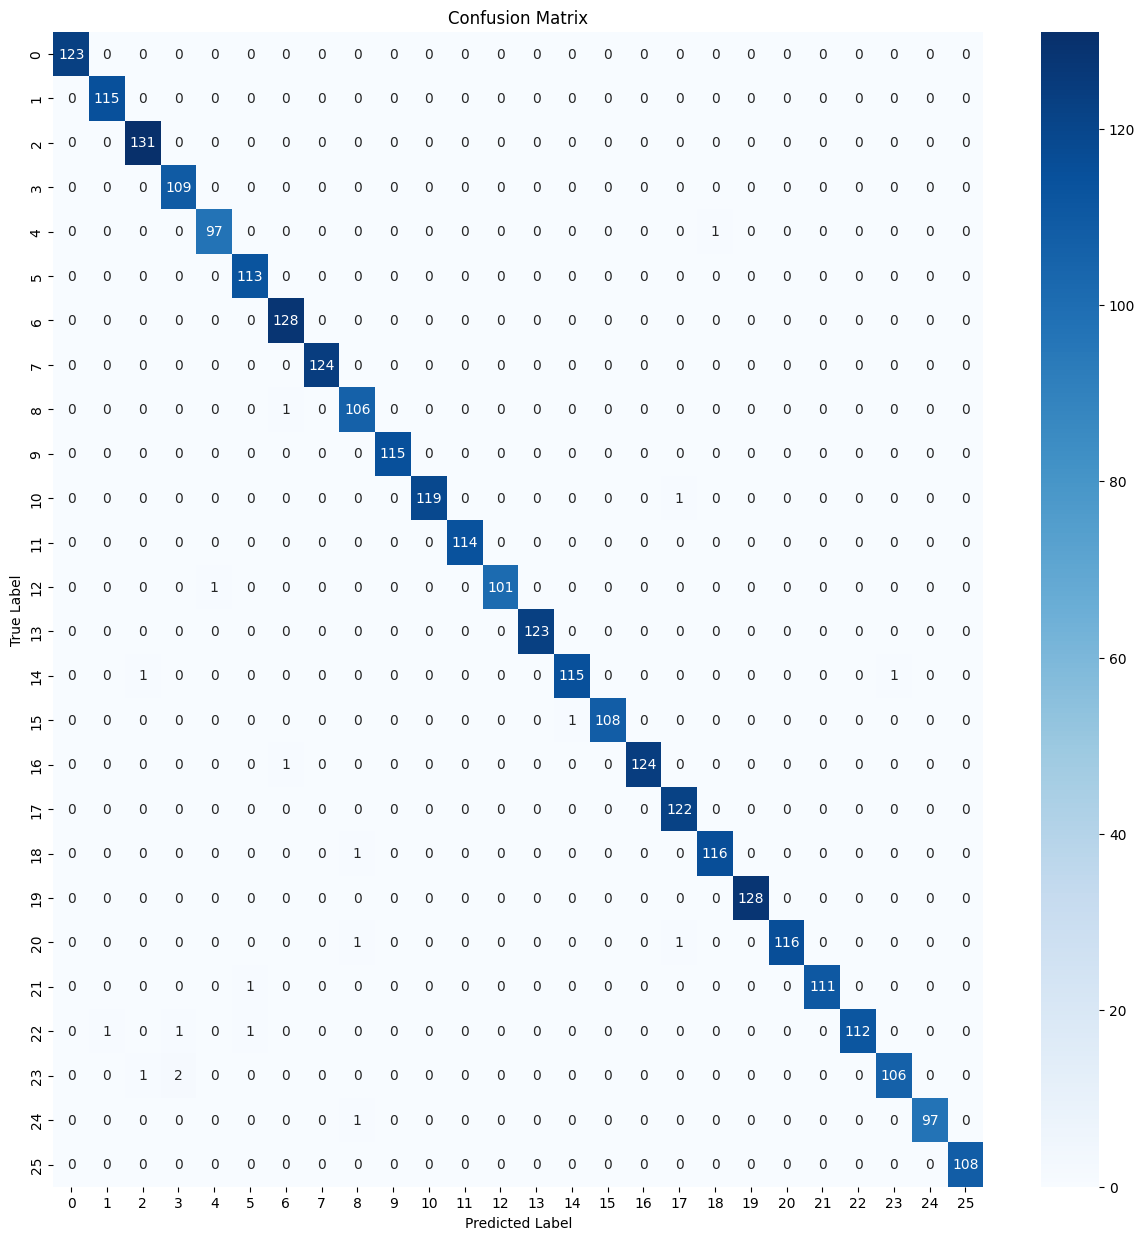

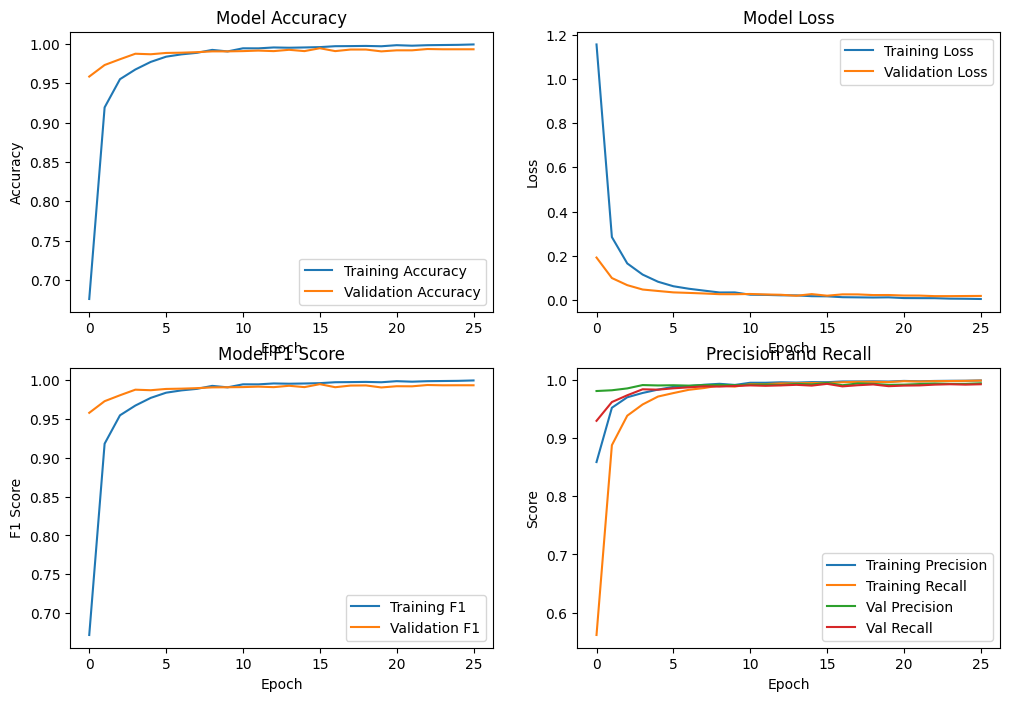


Classification Report:
               precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000       123
           b     0.9914    1.0000    0.9957       115
           c     0.9850    1.0000    0.9924       131
           d     0.9732    1.0000    0.9864       109
           e     0.9898    0.9898    0.9898        98
           f     0.9826    1.0000    0.9912       113
           g     0.9846    1.0000    0.9922       128
           h     1.0000    1.0000    1.0000       124
           i     0.9725    0.9907    0.9815       107
           j     1.0000    1.0000    1.0000       115
           k     1.0000    0.9917    0.9958       120
           l     1.0000    1.0000    1.0000       114
           m     1.0000    0.9902    0.9951       102
           n     1.0000    1.0000    1.0000       123
           o     0.9914    0.9829    0.9871       117
           p     1.0000    0.9908    0.9954       109
           q     1.0000    0.9920    0.9960       125
  

In [6]:
source_dir = "archive/Train_Alphabet"
processed_dir = "processed_dataset"
if not os.path.exists(processed_dir):
    prepare_dataset(source_dir, processed_dir)
train_dir, val_dir, test_dir = (os.path.join(processed_dir, split) for split in SPLITS)
model, history = train_model(train_dir, val_dir, test_dir, batch_size=32, epochs=50)